In [1]:
from tqdm import tqdm

In [2]:
import os
import numpy as np
import librosa
import soundfile as sf

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import os
import numpy as np
import librosa
from tqdm import tqdm
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

In [5]:
import soundfile as sf


In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [12]:
import os

folder_path = r"C:\Users\Dell\Downloads\emotion_det\final3\male"

wav_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]



In [16]:
len(wav_files)

1248

In [18]:
# wav_files

In [19]:
import os

def get_gender(filename):

    base = os.path.basename(filename)
    actor_id_str = base.split('-')[-1].split('.')[0]
    actor_id = int(actor_id_str)
    return 'male' if actor_id % 2 == 1 else 'female'



In [20]:
import os

def get_emotion_label(filename):
   
    base = os.path.basename(filename)
    parts = base.split('-')
    emotion_id = int(parts[2])
    return emotion_id - 1 



In [21]:
labels = []
for i in wav_files:
    labels.append(get_emotion_label(i))

In [24]:
train_files, test_files, train_labels, test_labels = train_test_split(
    wav_files, labels, test_size=0.2, random_state=42, stratify=labels
)

In [25]:
len(test_files)

250

## AUGMENT

In [26]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.7),
    PitchShift(min_semitones=-1.5, max_semitones=1.5, p=0.6),
    Shift(min_shift=-0.2, max_shift=0.2, shift_unit="fraction", p=0.5)
])

## EXTRACTION

In [27]:
def extract_features(audio, sr, n_mfcc=40, n_chroma=12, n_bands=6):
    stft = np.abs(librosa.stft(audio))

    # 1. MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_processed = np.vstack([
        np.mean(mfccs, axis=1),
        np.std(mfccs, axis=1),
        np.median(mfccs, axis=1)
    ])

   chroma = librosa.feature.chroma_stft(S=stft, sr=sr, n_chroma=n_chroma)
    chroma_processed = np.vstack([
        np.mean(chroma, axis=1),
        np.std(chroma, axis=1)
    ])
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr, n_bands=n_bands)
    contrast_processed = np.vstack([
        np.mean(contrast, axis=1),
        np.std(contrast, axis=1)
    ])

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
    tonnetz_processed = np.vstack([
        np.mean(tonnetz, axis=1),
        np.std(tonnetz, axis=1)
    ])

    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    flatness = librosa.feature.spectral_flatness(y=audio)

    spectral_features = np.array([
        np.mean(centroid), np.std(centroid),
        np.mean(bandwidth), np.std(bandwidth),
        np.mean(rolloff), np.std(rolloff),
        np.mean(flatness), np.std(flatness)
    ])

    zero_crossing = librosa.feature.zero_crossing_rate(audio)
    rms = librosa.feature.rms(y=audio)

    temporal_features = np.array([
        np.mean(zero_crossing), np.std(zero_crossing),
        np.mean(rms), np.std(rms)
    ])

    mel = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_processed = np.array([
        np.mean(mel), np.std(mel),
        np.median(mel), np.max(mel)
    ])

    features = np.hstack([
        mfccs_processed.flatten(),
        chroma_processed.flatten(),
        contrast_processed.flatten(),
        tonnetz_processed.flatten(),
        spectral_features,
        temporal_features,
        mel_processed
    ])

    return features


In [28]:
import numpy as np
import librosa
from tqdm import tqdm

SAMPLE_RATE = 16000  
NUM_AUGMENTATIONS = 3 

all_features = []
all_labels = []

for file_path in tqdm(train_files, desc="Processing audio", unit="file"):
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
        
        # Skip silent or empty files
        if audio is None or len(audio) == 0 or np.all(audio == 0):
            print(f"Warning: {file_path} is empty or silent, skipping.")
            continue

        # Original audio features
        features = extract_features(audio, sr)
        all_features.append(features)
        all_labels.append(get_emotion_label(file_path))

        # Augmented audio features
        for _ in range(NUM_AUGMENTATIONS):
            aug_audio = augment(samples=audio, sample_rate=SAMPLE_RATE)
            aug_features = extract_features(aug_audio, sr)
            all_features.append(aug_features)
            all_labels.append(get_emotion_label(file_path))

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Convert to arrays
train_features = np.array(all_features)
train_labels = np.array(all_labels)


Processing audio: 100%|████████████████████████████████████████████████████████████| 998/998 [20:20<00:00,  1.22s/file]


In [29]:
test_features = []
test_labels = []
for file_path in tqdm(test_files, desc="Processing audio", unit="file"):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
        
        if audio is None or len(audio) == 0 or np.all(audio == 0):
            print(f"Warning: {file_path} is empty or silent, skipping.")
            continue

        features = extract_features(audio, sr)
        test_features.append(features)
        test_labels.append(get_emotion_label(file_path))

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
test_features = np.array(test_features)
test_labels  = np.array(test_labels)

print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)

Processing audio: 100%|████████████████████████████████████████████████████████████| 250/250 [01:13<00:00,  3.42file/s]

Train features shape: (3992, 186)
Test features shape: (250, 186)


In [ ]:
np.unique(train_labels)

In [31]:
np.unique(test_labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

## CNN

In [33]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

num_classes = len(np.unique(train_labels))
y_train = to_categorical(train_labels, num_classes=num_classes)
y_test = to_categorical(test_labels, num_classes=num_classes)
X_train = train_features_scaled.reshape(train_features_scaled.shape[0], train_features_scaled.shape[1], 1)
X_test = test_features_scaled.reshape(test_features_scaled.shape[0], test_features_scaled.shape[1], 1)

model = Sequential([
    Conv1D(64, 5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

# 5. Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch 1/100


C:\Users\Dell\Downloads\emotion_det\emotion\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2329 - loss: 1.9485 - val_accuracy: 0.4880 - val_loss: 1.4910 - learning_rate: 5.0000e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4387 - loss: 1.5104 - val_accuracy: 0.5840 - val_loss: 1.2110 - learning_rate: 5.0000e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5037 - loss: 1.3280 - val_accuracy: 0.6080 - val_loss: 1.1073 - learning_rate: 5.0000e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5184 - loss: 1.2289 - val_accuracy: 0.6240 - val_loss: 0.9936 - learning_rate: 5.0000e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5641 - loss: 1.1355 - val_accuracy: 0.6280 - val_loss: 0.9838 - learning_rate: 5.0000e-04
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6036 - loss: 1.0555 - val_accuracy: 0.6640 - val_loss: 0.9347 - learning_rate: 5.0000e-04
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy

## RESULT

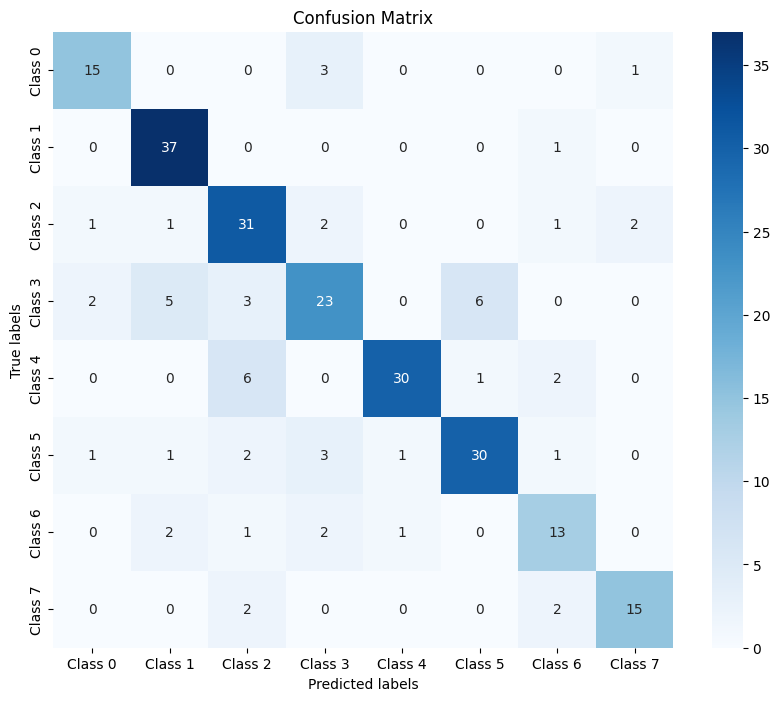

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        19
           1       0.80      0.97      0.88        38
           2       0.69      0.82      0.75        38
           3       0.70      0.59      0.64        39
           4       0.94      0.77      0.85        39
           5       0.81      0.77      0.79        39
           6       0.65      0.68      0.67        19
           7       0.83      0.79      0.81        19

    accuracy                           0.78       250
   macro avg       0.78      0.77      0.77       250
weighted avg       0.78      0.78      0.77       250



In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


## DUMPING

In [37]:
import joblib
import os

save_dir = r"C:\Users\Dell\Downloads\emotion_det\final3\male_models"

model_path = os.path.join(save_dir, "male_model.keras")
joblib.dump(model, model_path)
scaler_path = os.path.join(save_dir, "male_scaler.keras")
joblib.dump(scaler, scaler_path)


['C:\\Users\\Dell\\Downloads\\emotion_det\\final3\\male_models\\male_scaler.keras']

In [38]:
a = os.path.join(save_dir, "train_features_male.keras")
b = os.path.join(save_dir, "test_features_male.keras")

c = os.path.join(save_dir, "train_lables_male.keras")
d = os.path.join(save_dir, "test_labels_male.keras")

joblib.dump(train_features,a)
joblib.dump(test_features,b)
joblib.dump(train_labels,c)
joblib.dump(test_labels,d)

['C:\\Users\\Dell\\Downloads\\emotion_det\\final3\\male_models\\test_labels_male.keras']